# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract features from them. 
Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [ ]:
trainval_tb, test_tb = preprocessor.preprocess(target_col=['v_lp'], 
                                               path=data_path,
                                               lidar_pref='AV_las',
                                               image_pref='AV_tif',
                                               mask_plot=False,
                                               min_h=1.3,
                                               normalize=True,
                                               log_y=False,
                                               
                                               save_path='../../enveco_data'
                                              )

If all features are already preprocessed, it's possible to use saved features and save a bit of time.

In [282]:
trainval_tb, test_tb = preprocessor.load_las_image(path='../../enveco_data', target_col=['v'], log_y=False)

Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [283]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [284]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [285]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [286]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [287]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, mae, bias, bias_pct, R2Score()],
                        y_range=(Tensor([0 for _ in range(dls.c)]), Tensor(trainval_tb.train.ys.max().values*1.1))
                        #y_range=(0, trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: 64 x torch.Size([64, 174]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 174            
BatchNorm1d                               348        True      
BatchNorm1d                               348        True      
____________________________________________________________________________
                     64 x 200            
Linear                                    34800      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 1              
Linear                            

Find learning rate to use.

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0020892962347716093)

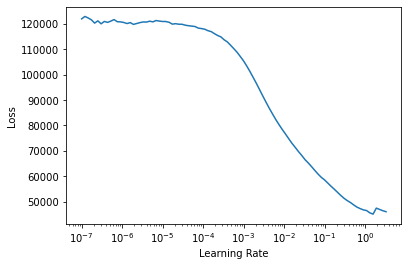

In [288]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,mae,_bias,_bias_pct,r2_score,time
0,66307.445312,48374.171875,219.941315,145.880051,206.993347,200.170258,132.766525,-4.315375,00:00
1,35044.492188,7691.063477,87.698708,58.167751,62.749500,7.908251,5.245290,0.154903,00:00
2,21548.779297,7360.833008,85.795303,56.905281,60.684048,1.492041,0.989623,0.191189,00:00
3,14925.705078,3313.009521,57.558750,38.176876,44.772141,-24.884769,-16.505272,0.635965,00:00
4,10554.933594,2884.840332,53.710712,35.624596,37.076736,2.927446,1.941681,0.683012,00:00
5,7788.642090,3023.082520,54.982563,36.468174,35.177189,-7.691835,-5.101748,0.667822,00:00
6,5888.078125,2919.346680,54.030979,35.837021,36.722858,10.747048,7.128173,0.679221,00:00
7,4638.389648,2365.543213,48.636848,32.259266,33.222450,-8.958727,-5.942037,0.740073,00:00
8,3737.895020,1872.387085,43.271088,28.700329,30.753864,-0.224899,-0.149168,0.794261,00:00
9,3123.400146,2272.327393,47.668938,31.617281,32.544060,10.955029,7.266119,0.750316,00:00


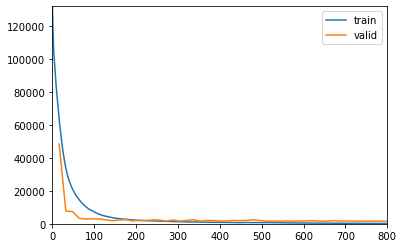

In [289]:
learn.fit_one_cycle(50, lr_max=1e-2, cbs=ShowGraphCallback())

See validation results

In [290]:
learn.validate()

(#7) [1627.1380615234375,40.33780288696289,26.754776000976562,27.716590881347656,5.4171648025512695,3.593032121658325,0.8212093512083036]

In [291]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [292]:
reg_interp = RegressionInterpretation.from_learner(learn)

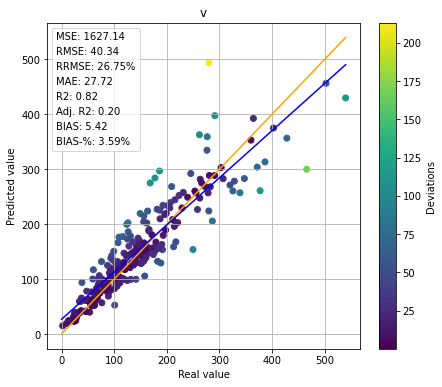

In [293]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [294]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [295]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

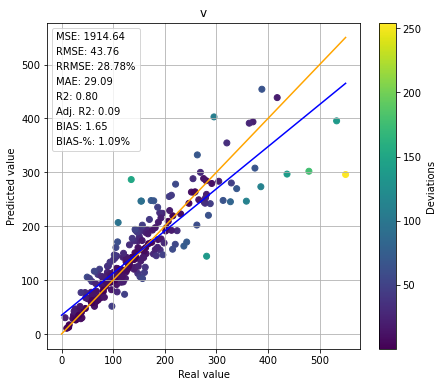

In [296]:
test_interp.plot_results(log_y=False)
plt.show()

In [297]:
test_preds = learn.get_preds(dl=test_dls.train)

# Ensemble of ANNs

Fit several models at once.

In [298]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensembles',
                    #y_range=(Tensor([0 for _ in range(dls.c)]), Tensor(trainval_tb.train.ys.max().values*1.1)),
                    y_range=(0, trainval_tb.train.y.max()*1.1),
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [299]:
ensemble.fit_one_cycle(50, 1e-2)

In [300]:
res = ensemble.validate()

See ensemble validation results.

In [301]:
for r in res:
    print(r)

   model_identifier      _rmse     _rrmse     _bias  _bias_pct        mae  \
0          ensemble  38.566448  25.579891  2.703619   1.793224  26.239254   
1               0.0  42.297100  28.054316  1.449576   0.961457  28.234032   
2               1.0  40.528133  26.881016  0.182482   0.121034  26.719461   
3               2.0  40.306053  26.733715  2.786197   1.847996  27.548197   
4               3.0  42.610065  28.261894  4.538857   3.010479  29.125156   
5               4.0  35.668705  23.657911  3.288834   2.181378  25.403162   
6               5.0  43.306633  28.723904  6.279014   4.164669  28.315331   
7               6.0  41.479309  27.511898  0.589621   0.391077  27.855738   
8               7.0  38.972057  25.848919  2.089949   1.386196  27.215698   
9               8.0  41.532223  27.546995 -0.151247  -0.100317  27.411911   
10              9.0  39.538342  26.224518  5.982911   3.968273  27.957951   

    r2_score  
0   0.836567  
1   0.803419  
2   0.819518  
3   0.821491  


In [302]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

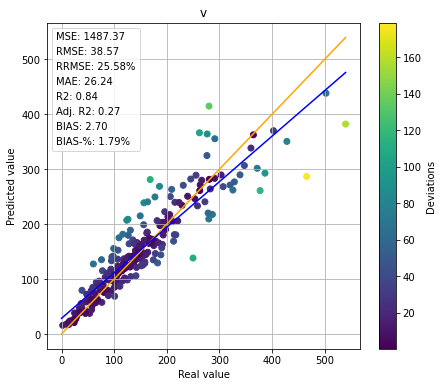

In [303]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [304]:
ens_preds = ensemble.get_ensemble_preds(dl=test_dls[0])

In [305]:
model_results = []
for m in ensemble.models:
    model_results.append(m.get_preds(dl=test_dls[0], reorder=False, with_input=True))

In [306]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

[   model_identifier      _rmse     _rrmse     _bias  _bias_pct        mae  \
 0          ensemble  38.640842  25.419325 -1.396182  -0.918458  25.735006   
 1               0.0  41.335052  27.191671 -2.198390  -1.446179  26.909134   
 2               1.0  40.794205  26.835886 -3.414407  -2.246119  27.068283   
 3               2.0  39.858154  26.220116 -1.602346  -1.054080  26.712009   
 4               3.0  40.749271  26.806324 -0.819419  -0.539043  27.395975   
 5               4.0  42.649616  28.056440 -1.045962  -0.688071  28.972990   
 6               5.0  39.770824  26.162668  0.176013   0.115788  27.815868   
 7               6.0  38.755703  25.494884 -0.388808  -0.255772  26.461142   
 8               7.0  40.495384  26.639309 -1.139628  -0.749688  27.388334   
 9               8.0  40.569679  26.688183 -3.351074  -2.204456  26.709154   
 10              9.0  39.404339  25.921579 -0.177787  -0.116954  26.714247   
 
     r2_score  
 0   0.841335  
 1   0.818438  
 2   0.823158 

In [307]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

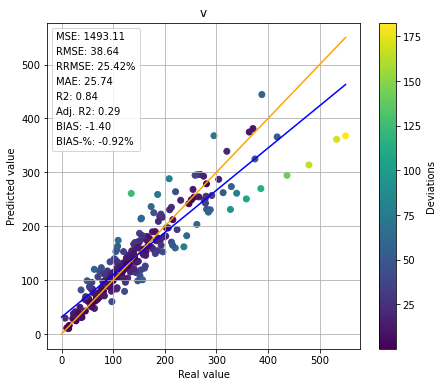

In [308]:
test_ens_interp.plot_results(log_y=False)
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [144]:
from sklearn.ensemble import RandomForestRegressor

Below values for `max_features` and `min_samples_leaf` should generally work well.

In [145]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [146]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [147]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

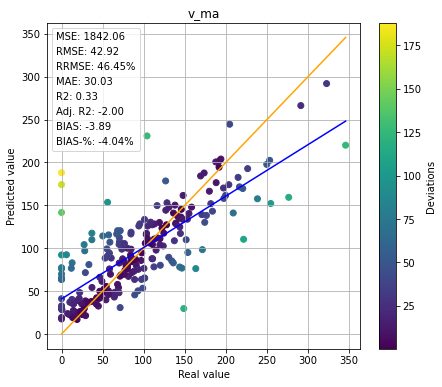

In [148]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

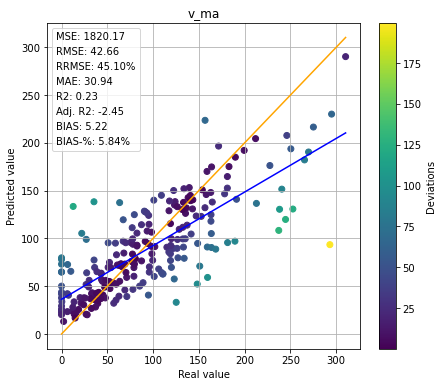

In [149]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()